In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

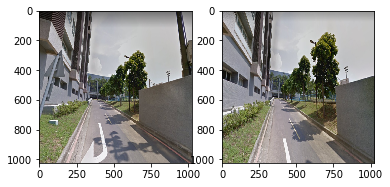

In [2]:
img1 = cv2.imread('./images/img1.png')#dist
img2 = cv2.imread('./images/img2.png')#src
img1 = cv2.resize(img1, (1024, 1024))
img2 = cv2.resize(img2, (1024, 1024))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()
h,w, _ = img1.shape
img2_scaled = cv2.resize(img2, (int(w/2), int(h/2)))
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2_scaled, cv2.COLOR_BGR2GRAY)
img1_target = img1_gray[int(h/4):-int(h/4), int(w/4):-int(w/4)]
img2_target = img2_gray

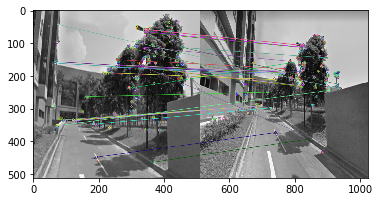

In [3]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1_target, None)
kp2, des2 = orb.detectAndCompute(img2_target, None)

# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
matches = matches[:int(len(matches)*0.15)]

plt.imshow(cv2.cvtColor(cv2.drawMatches(img1_target, kp1, img2_target, kp2, matches, None), cv2.COLOR_BGR2RGB))

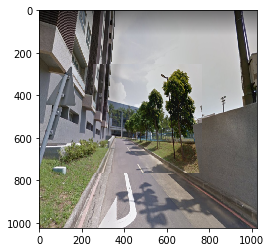

In [4]:
#stitch images together
src_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
dst_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

img_warp = cv2.warpPerspective(img2_scaled, M, (int(w/2), int(h/2)))
img_result = img1[:, :, :]
for i in range(int(h/2)):
    for j in range(int(w/2)):
        if sum(img_warp[i, j, :]) != 0:
            if h/4+i < h*3/4 and w/4+j < w*3/4:
                img_result[int(h/4)+i, int(w/4)+j, :] = img_warp[i, j, :]
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))

In [5]:
def stitch(img1, img2, scale):
    h,w, _ = img1.shape
    img2_scaled = cv2.resize(img2, (int(w*scale), int(h*scale)))
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2_scaled, cv2.COLOR_BGR2GRAY)
    img1_target = img1_gray[int(h/2-h*scale/2):int(h/2+h*scale/2), int(w/2-w*scale/2):int(w/2+w*scale/2)]
    img2_target = img2_gray

    # Initiate ORB detector
    orb = cv2.ORB_create()

    # find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1_target, None)
    kp2, des2 = orb.detectAndCompute(img2_target, None)

    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    matches = matches[:int(len(matches)*0.15)]
    plt.imshow(cv2.cvtColor(cv2.drawMatches(img1_target, kp1, img2_target, kp2, matches, None), cv2.COLOR_BGR2RGB))
    plt.show()

    #stitch images together
    src_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

    img_warp = cv2.warpPerspective(img2_scaled, M, (int(w*scale), int(h*scale)))
    img_result = img1[:, :, :]
    #img_result[int(h/2-h*scale/2):int(h/2+h*scale/2), int(w/2-w*scale/2):int(w/2+w*scale/2), :] = img_warp
    for i in range(int(h*scale)):
        for j in range(int(w*scale)):
            if sum(img_warp[i, j, :]) != 0:
                if h/2-h*scale/2+i < h/2+h*scale/2 and h/2-h*scale/2+i < h and w/2-w*scale/2+j < w/2+w*scale/2 and w/2-w*scale/2+j < w:
                    img_result[int(h/2-h*scale/2)+i, int(w/2-w*scale/2)+j, :] = img_warp[i, j, :]
    return img_result

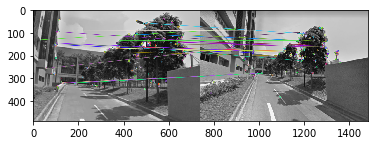

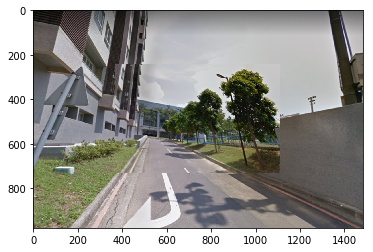

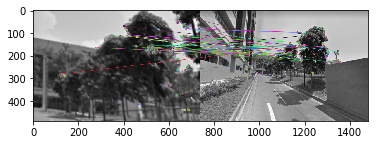

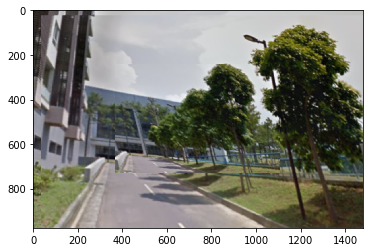

In [6]:
from PIL import Image
frames = []
img = []
img_num = 3
for i in range(img_num):
    img.append(cv2.imread('./images/img%d.png'%(i+1)))


result = img[0]
for i in range(img_num-1):
    h,w, _ = result.shape
    scale = 2
    img2_gray = cv2.cvtColor(img[i+1], cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2_gray, cv2.COLOR_GRAY2BGR)
    img1_scaled = cv2.resize(result, (int(w*scale), int(h*scale)))
    result = stitch(img1_scaled, img2, 0.5)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.show()
    scale_f = 1
    while scale_f<=2:
        frame = cv2.resize(result, (int(w*scale_f), int(h*scale_f)))
        h1, w1, _ = frame.shape
        frame = frame[int(h1/2)-int(h/2):int(h1/2)+int(h/2), int(w1/2)-int(w/2):int(w1/2)+int(w/2), :]
        frames.append(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))
        scale_f += 0.05
    result = result[int(h1/2)-int(h/2):int(h1/2)+int(h/2), int(w1/2)-int(w/2):int(w1/2)+int(w/2), :]

In [7]:
from IPython.display import Image as IPImage
import math
frames[0].save('output.gif', save_all=True, append_images=frames[1:], loop = 0xffff, duration = 250)
IPImage(url='./output.gif')